# Launch deployment

In [ ]:
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(
    n_workers=int(mp.cpu_count()*0.9))
#client = Client(cluster)
#client = Client()

In [23]:
client

Client Scheduler: tcp://127.0.0.1:43509 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 20 Cores: 20 Memory: 107.37 GB


In [21]:
client.close()
cluster.close()

In [1]:
import numpy as np 
import pandas as pd

data_df = pd.read_csv('data/XRF_ML_cr.csv')
X = data_df.iloc[:, 1:-2]
y = data_df['facies_merge_1']
groups = data_df['core_section']

In [2]:
import numpy as np 
import pandas as pd
from split import my_train_test_split
data_df = pd.read_csv('data/XRF_ML_cr.csv')
X = data_df.iloc[:, 1:-2].values
y = data_df['facies_merge_1'].values
#groups, categories = pd.factorize(data_df['core_section'])
groups = data_df['core_section'].values

#train_idx, test_idx = my_train_test_split(X, y, groups)
X_train, X_test, y_train, y_test, groups_train, groups_test = my_train_test_split(X, y, groups)

In [5]:
%%time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from split import my_group_stratify_shuffle_cv

lr = make_pipeline(StandardScaler(), PCA(whiten = True), LogisticRegression(max_iter = 10000, class_weight = 'balanced'))

param_grid = {'logisticregression__C': [10**_ for _ in range(-4, 0)]}

mycv = my_group_stratify_shuffle_cv(X_train, y_train, groups_train)

grid = GridSearchCV(lr, param_grid = param_grid, cv = mycv, scoring = 'balanced_accuracy', n_jobs = -1)

grid.fit(X_train, y_train)

print("Best score on validation set: {:.2f}".format(grid.best_score_)) 
print("Best parameters: ", grid.best_params_)

Best score on validation set: 0.58
Best parameters:  {'logisticregression__C': 0.1}
CPU times: user 32.7 s, sys: 3.33 s, total: 36 s
Wall time: 13min 58s


In [6]:
%%time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from dask_ml.model_selection import GridSearchCV
from split import my_group_stratify_shuffle_cv

lr = make_pipeline(StandardScaler(), PCA(whiten = True), LogisticRegression(max_iter = 10000, class_weight = 'balanced', n_jobs = -1))

param_grid = {'logisticregression__C': [10**_ for _ in range(-4, 0)]}

mycv = my_group_stratify_shuffle_cv(X_train, y_train, groups_train)

grid = GridSearchCV(lr, param_grid = param_grid, cv = mycv, scoring = 'balanced_accuracy', n_jobs = 20)

grid.fit(X_train, y_train)

print("Best score on validation set: {:.2f}".format(grid.best_score_)) 
print("Best parameters: ", grid.best_params_)

Best score on validation set: 0.58
Best parameters:  {'logisticregression__C': 0.1}
CPU times: user 29.6 s, sys: 3.24 s, total: 32.8 s
Wall time: 3min 49s


In [9]:
lr_df = pd.DataFrame(grid.cv_results_)

# Plot

In [11]:
import numpy as np 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')
#mpl.rcParams['xtick.labelsize'] = 8
#mpl.rcParams["image.cmap"] = 'gray'
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

import datetime
date = datetime.datetime.now().strftime('%Y%m%d')

%matplotlib inline

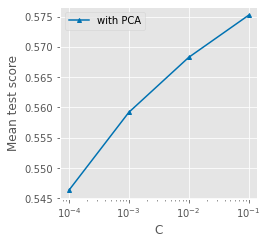

In [15]:
max_index = np.argmax(lr_df.mean_test_score)

fig = plt.figure(figsize = (3.54, 3.54))
plt.xscale('log')
#plt.ylim(0.61, 0.68)
#plt.plot(lr_noPCA_df.param_logisticregression__C, lr_noPCA_df.mean_test_score, marker = 'o', ms = 4, label = 'without PCA')
plt.plot(lr_df.param_logisticregression__C, lr_df.mean_test_score, marker = '^', ms = 4, label = 'with PCA')
#plt.yticks(np.linspace(0.625, 0.675, 3))
plt.ylabel('Mean test score')
plt.xlabel('C')
plt.legend()

#plt.annotate(s = 'Best score = {:.3f}\nC = {}'.format(lr_df.mean_test_score[max_index], lr_df.param_logisticregression__C[max_index]),
#             xy = (lr_df.param_logisticregression__C[max_index], lr_df.mean_test_score[max_index]-.001),
#             xytext = (0.1, 0.625), arrowprops=dict(facecolor='gray', arrowstyle = 'fancy')
#            )
fig.subplots_adjust(wspace = 0.05)
#fig.savefig('analysis_ML/results/20200901_lr_grid_results_combined.png')

In [4]:
%%time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from dask_ml.model_selection import GridSearchCV
from split import my_group_stratify_shuffle_cv

lr = make_pipeline(StandardScaler(), PCA(whiten = True), LogisticRegression(max_iter = 10000, class_weight = 'balanced'))

param_grid = {'logisticregression__C': [10**_ for _ in range(-4, 6)]}

mycv = my_group_stratify_shuffle_cv(X_train, y_train, groups_train)

grid = GridSearchCV(lr, param_grid = param_grid, cv = mycv, scoring = 'balanced_accuracy', n_jobs = -1)

grid.fit(X_train, y_train)

print("Best score on validation set: {:.2f}".format(grid.best_score_)) 
print("Best parameters: ", grid.best_params_)

/home/users/aslee/miniconda3/lib/python3.7/site-packages/distributed/worker.py:3382: UserWarning: Large object of size 5.25 MB detected in task graph: 
  (_CVIterableWrapper(cv=[(array([     0,      1, .. ... e, False, True)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)
distributed.scheduler - ERROR - Couldn't gather keys {"('score-d4e69ff487e977c5429e39a42cc1e85a', 0, 3)": ['tcp://127.0.0.1:40163']} state: ['memory'] workers: ['tcp://127.0.0.1:40163']
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://127.0.0.1:40163'], ('score-d4e69ff487e977c5429e39a42cc1e85a', 0, 3)
NoneType: None
distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('score-d4e69ff487e977c5429e39a42cc1e

KeyError: "('logisticregression-fit-d4e69ff487e977c5429e39a42cc1e85a', 7, 0)"

distributed.scheduler - ERROR - Couldn't gather keys {"('score-d4e69ff487e977c5429e39a42cc1e85a', 4, 3)": ['tcp://127.0.0.1:40163']} state: ['memory'] workers: ['tcp://127.0.0.1:40163']
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://127.0.0.1:40163'], ('score-d4e69ff487e977c5429e39a42cc1e85a', 4, 3)
NoneType: None
distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('score-d4e69ff487e977c5429e39a42cc1e85a', 4, 3)": ('tcp://127.0.0.1:40163',)}
distributed.scheduler - ERROR - Couldn't gather keys {"('score-d4e69ff487e977c5429e39a42cc1e85a', 4, 3)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('score-d4e69ff487e977c5429e39a42cc1e85a', 4, 3)
NoneType: None
distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('score-d4e69ff487e977c5429e39a42cc1e85a', 4, 3)": ()}
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killin

In [7]:
%%time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from split import my_group_stratify_shuffle_cv

lr = make_pipeline(StandardScaler(), PCA(whiten = True), LogisticRegression(max_iter = 10000, class_weight = 'balanced'))

param_grid = {'logisticregression__C': [10**_ for _ in range(-4, 6)]}

mycv = my_group_stratify_shuffle_cv(X_train, y_train, groups_train)

grid = GridSearchCV(lr, param_grid = param_grid, cv = mycv, scoring = 'balanced_accuracy', n_jobs = -1)

grid.fit(X_train, y_train)

print("Best score on validation set: {:.2f}".format(grid.best_score_)) 
print("Best parameters: ", grid.best_params_)

Best score on validation set: 0.58
Best parameters:  {'logisticregression__C': 1}
CPU times: user 2min 12s, sys: 2.17 s, total: 2min 14s
Wall time: 4min 54s


In [ ]:
%%time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from dask_ml.model_selection import GridSearchCV
from split import my_group_stratify_shuffle_cv

svc = make_pipeline(StandardScaler(), PCA(whiten = True), SVC(class_weight = 'balanced'))
param_grid = {'svc__C': np.logspace(-3, 5, 9),
             'svc__gamma': np.logspace(-6, 0, 7)}

mycv = my_group_stratify_shuffle_cv(X_train, y_train, groups_train)

grid = GridSearchCV(svc, param_grid = param_grid, cv = mycv, scoring = 'balanced_accuracy', n_jobs = 50)

grid.fit(X_train, y_train)

print("Best score on validation set: {:.2f}".format(grid.best_score_)) 
print("Best parameters: ", grid.best_params_)

In [24]:
#from split import my_train_test_split
import dask.dataframe as dd
data_df = dd.read_csv('data/XRF_ML_cr.csv')
X = data_df.iloc[:, 1:-2]
y = data_df['facies_merge_1']
#groups, categories = pd.factorize(data_df['core_section'])
groups = data_df['core_section']

#train_idx, test_idx = my_train_test_split(X, y, groups)
#X_train, X_test, y_train, y_test, groups_train, groups_test = my_train_test_split(X, y, groups)

In [16]:
%%time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from dask_ml.model_selection import GridSearchCV

lr = make_pipeline(StandardScaler(), PCA(whiten = True), LogisticRegression(max_iter = 10000, class_weight = 'balanced'))

param_grid = {'logisticregression__C': [10**_ for _ in range(-4, 6)]}

grid = GridSearchCV(lr, param_grid = param_grid, scoring = 'balanced_accuracy', n_jobs = -1)

grid.fit(X, y)

print("Best score on validation set: {:.2f}".format(grid.best_score_)) 
print("Best parameters: ", grid.best_params_)

Best score on validation set: 0.59
Best parameters:  {'logisticregression__C': 0.001}
CPU times: user 3.22 s, sys: 488 ms, total: 3.71 s
Wall time: 2min 6s


In [25]:
%%time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from dask_ml.model_selection import GridSearchCV

lr = make_pipeline(StandardScaler(), PCA(whiten = True), LogisticRegression(max_iter = 10000, class_weight = 'balanced'))

param_grid = {'logisticregression__C': [10**_ for _ in range(-4, 6)]}

grid = GridSearchCV(lr, param_grid = param_grid, cv=5, scoring = 'balanced_accuracy', n_jobs = -1)

grid.fit(X, y)

print("Best score on validation set: {:.2f}".format(grid.best_score_)) 
print("Best parameters: ", grid.best_params_)

distributed.scheduler - ERROR - Couldn't gather keys {"('score-d6209927d89f532a3dd48d7291803e61', 2, 2)": ['tcp://127.0.0.1:39855']} state: ['memory'] workers: ['tcp://127.0.0.1:39855']
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://127.0.0.1:39855'], ('score-d6209927d89f532a3dd48d7291803e61', 2, 2)
NoneType: None
distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('score-d6209927d89f532a3dd48d7291803e61', 2, 2)": ('tcp://127.0.0.1:39855',)}
Task exception was never retrieved
future: <Task finished coro=<connect.<locals>._() done, defined at /home/users/aslee/miniconda3/lib/python3.7/site-packages/distributed/comm/core.py:288> exception=CommClosedError()>
Traceback (most recent call last):
  File "/home/users/aslee/miniconda3/lib/python3.7/site-packages/distributed/comm/core.py", line 298, in _
    write = await asyncio.wait_for(comm.write(local_info), 1)
  File "/home/users/aslee/miniconda3/lib/python3.7/asyncio/tasks.py", li

Best score on validation set: 0.61
Best parameters:  {'logisticregression__C': 0.001}
CPU times: user 1min 52s, sys: 15.8 s, total: 2min 8s
Wall time: 19min 52s
